In [1]:
#package imports
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sys.path.append('../')
from src.models import street_view_cnn
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

### Input Data Prep

In [2]:
sam1= pd.read_csv('../labels/training_labels_updated_111219.csv')
sam2 = pd.read_csv('../labels/additional_training_labels_120319.csv')
sample=pd.concat([sam1, sam2], axis = 0)
assert sample.shape[0] == sam1.shape[0] + sam2.shape[0]

# option to include additional labels - trained with these on a GPU
# sample3 = pd.read_csv('../labels/new6000_training_labels_aerial.csv', index_col='Unnamed: 0') 

In [3]:
# take a look at the top
sample.head()

,ADDRESS_FOR_STREET_VIEW,ADDR_NUM,AERIAL_Driveway,FULL_STR,GSV_Driveway,MBL,aerial_addr,aerial_filename,final_label,gsv_filename,sv_addr,three_class_label
0,"5 DOUGLAS AVE, SOMERVILLE, MA",5,2.0,DOUGLAS AVE,0.0,47-G-17,NaN,5_DOUGLAS_AVE_aerial.png,0.1,5_DOUGLAS_AVE.jpg,NaN,NaN
1,"6 HILLSIDE CIR, SOMERVILLE, MA",6,1.0,HILLSIDE CIR,2.0,38-A-47,NaN,6_HILLSIDE_CIR_aerial.png,0.9,6_HILLSIDE_CIR.jpg,NaN,NaN
2,"8 BELMONT PL, SOMERVILLE, MA",8,2.0,BELMONT PL,2.0,44-A-48,NaN,8_BELMONT_PL_aerial.png,0.5,8_BELMONT_PL.jpg,NaN,NaN
3,"8 DRESDEN CIR, SOMERVILLE, MA",8,2.0,DRESDEN CIR,2.0,25-A-13,NaN,8_DRESDEN_CIR_aerial.png,0.5,8_DRESDEN_CIR.jpg,NaN,NaN
4,"8 HAWTHORNE ST, SOMERVILLE, MA",8,0.0,HAWTHORNE ST,2.0,25-D-16,NaN,8_HAWTHORNE_ST_aerial.png,0.1,8_HAWTHORNE_ST.jpg,NaN,NaN


In [4]:
# This is the street view model - train on steet view driveway labels
sample['GSV_Driveway'] = sample['GSV_Driveway'].astype('int').astype('str')
sample.loc[sample['GSV_Driveway'] == '2', 'GSV_Driveway'] = '0' #<- this is to make sure we only have two labels

In [6]:
# now split into train and validation (calling it test here)
train_data, test_data = train_test_split(sample, test_size = 0.2, random_state = 100)
y_column = 'GSV_Driveway'

For street view driveways, we have three labelled classes (0: no driveway; 1: driveway; 2: unsure)  
We tried two variants of models:
1. Learn these three classes
2. Set 0 and 2 to be the same class - we want to be able to predict the driveways accurately

This notebook shows option 2.

### Minority class oversampling

In [7]:
display(train_data.groupby(y_column).aggregate({'MBL':len}))
display(test_data.groupby(y_column).aggregate({'MBL':len}))

,MBL
GSV_Driveway,
0,192
1,328


,MBL
GSV_Driveway,
0,43
1,87


In [8]:
# artificially oversample the minority class - TRAINING
zero_class = train_data[train_data[y_column] == '0']
one_class = train_data[train_data[y_column] == '1']

train_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0]-1):
    train_data = train_data.append(zero_class)

In [9]:
# artificially oversample the minority class - TEST
zero_class = test_data[test_data[y_column] == '0']
one_class = test_data[test_data[y_column] == '1']

test_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0]-1):
    test_data = test_data.append(zero_class)

In [10]:
# display(train_data.groupby(y_column).aggregate({'MBL':len}))
# display(test_data.groupby(y_column).aggregate({'MBL':len}))

### Modelling

In [8]:
# set input params
sv_image_dim = (128, 128, 3)
lr = 1e-4
batch_size = 256
val_batch_size = 256

In [9]:
# define optimizer - adam 
optimizer = keras.optimizers.Adam(lr=lr)

# define learning rate decay method - two options
# lr_decay = tensorflow.keras.callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.9 ** epoch)) 
lr_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.1, 
                                                        patience=2, 
                                                        verbose=True, 
                                                        mode='auto',
                                                        min_delta=0.0001, 
                                                        cooldown=1, 
                                                        min_lr=1e-9)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=0.001,
                                               patience=5, 
                                               verbose=True,
                                               mode='auto', 
                                               baseline=None, 
                                               restore_best_weights=True)

# define loss - cat xentropy
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.1) #smoothed labels

In [10]:
# define pretrained model 
pretrained_model = keras.applications.resnet50.ResNet50(include_top=False, input_shape=sv_image_dim)
print('number of layers in pretrained model: ', len(pretrained_model.layers))

# I tried unfreezing none to some - more fine tuning required here but not sure it makes much of a diff atm
for layer in pretrained_model.layers[:-80]:
    layer.trainable = False

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


number of layers in pretrained model:  175


In [11]:
# build model using function from models.py
model = street_view_cnn(pretrained_model, 
                        image_dim = sv_image_dim, 
                        optimizer = optimizer,
                        loss = loss,
                        n_classes=2,
                        activation = 'sigmoid',
                        metrics=['accuracy'], 
                       )

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
streetview_image_input (Inpu [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3276900   
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_______________________________________________

### Generator

In [12]:
# inputs to generator
image_dir = '../data/training/sv_images/'
x_column = 'gsv_filename'
color_mode = 'rgb'

In [13]:
gen_obj = ImageDataGenerator(rescale=1.0/255.0, 
                             zoom_range = 0.2 #adding zoom range as some images are super zoomed in/out
                            ) 

## train
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            seed=10)

## test (i.e. validation)
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=val_batch_size, 
                                            shuffle=True,
                                            seed=10)

Found 880 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3523 invalid image filename(s) in x_col="gsv_filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 889 invalid image filename(s) in x_col="gsv_filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


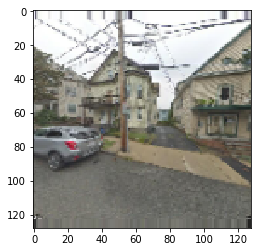

In [15]:
# check thaat the generator works
store = next(train_generator)
plt.imshow(store[0][2]);

In [17]:
# training parameters
epochs = 30
val_steps = test_data.shape[0]//val_batch_size

# train model
history = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1,
                              callbacks=[lr_decay]
#                               callbacks=[lr_decay, early_stopping]
                             )

Epoch 1/30
17/17 [==============================] - 44s 3s/step - loss: 2.6306 - acc: 0.9359 - val_loss: 2.6895 - val_acc: 0.9198
Epoch 2/30
17/17 [==============================] - 36s 2s/step - loss: 2.4396 - acc: 0.9708 - val_loss: 2.5027 - val_acc: 0.9198
Epoch 3/30
17/17 [==============================] - 38s 2s/step - loss: 2.2759 - acc: 0.9846 - val_loss: 2.3406 - val_acc: 0.9198
Epoch 4/30
17/17 [==============================] - 40s 2s/step - loss: 2.1176 - acc: 0.9898 - val_loss: 2.1796 - val_acc: 0.9198
Epoch 5/30
17/17 [==============================] - 37s 2s/step - loss: 1.9762 - acc: 0.9909 - val_loss: 2.0535 - val_acc: 0.9198
Epoch 6/30
17/17 [==============================] - 36s 2s/step - loss: 1.8391 - acc: 0.9955 - val_loss: 1.9311 - val_acc: 0.9198
Epoch 7/30
17/17 [==============================] - 39s 2s/step - loss: 1.7194 - acc: 0.9944 - val_loss: 1.8151 - val_acc: 0.9198
Epoch 8/30
17/17 [==============================] - 41s 2s/step - loss: 1.6084 - acc: 0.99

In [20]:
# # train model
history1 = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1,
                              callbacks=[lr_decay, early_stopping])

Epoch 1/30
17/17 [==============================] - 43s 3s/step - loss: 0.5992 - acc: 0.9972 - val_loss: 0.7269 - val_acc: 0.9198
Epoch 2/30
17/17 [==============================] - 37s 2s/step - loss: 0.5844 - acc: 0.9976 - val_loss: 0.7165 - val_acc: 0.9198
Epoch 3/30
17/17 [==============================] - 38s 2s/step - loss: 0.5707 - acc: 0.9971 - val_loss: 0.7041 - val_acc: 0.9198
Epoch 4/30
17/17 [==============================] - 40s 2s/step - loss: 0.5578 - acc: 0.9977 - val_loss: 0.6905 - val_acc: 0.9198
Epoch 5/30
17/17 [==============================] - 37s 2s/step - loss: 0.5462 - acc: 0.9983 - val_loss: 0.6815 - val_acc: 0.9198
Epoch 6/30
17/17 [==============================] - 36s 2s/step - loss: 0.5358 - acc: 0.9974 - val_loss: 0.6794 - val_acc: 0.9198
Epoch 7/30
17/17 [==============================] - 38s 2s/step - loss: 0.5256 - acc: 0.9968 - val_loss: 0.6680 - val_acc: 0.9198
Epoch 8/30
17/17 [==============================] - 41s 2s/step - loss: 0.5173 - acc: 0.99

In [21]:
hist = {}
for key in history.history.keys():
    hist[key] = history.history[key] + history1.history[key] #+ history2.history[key]  + history3.history[key] 

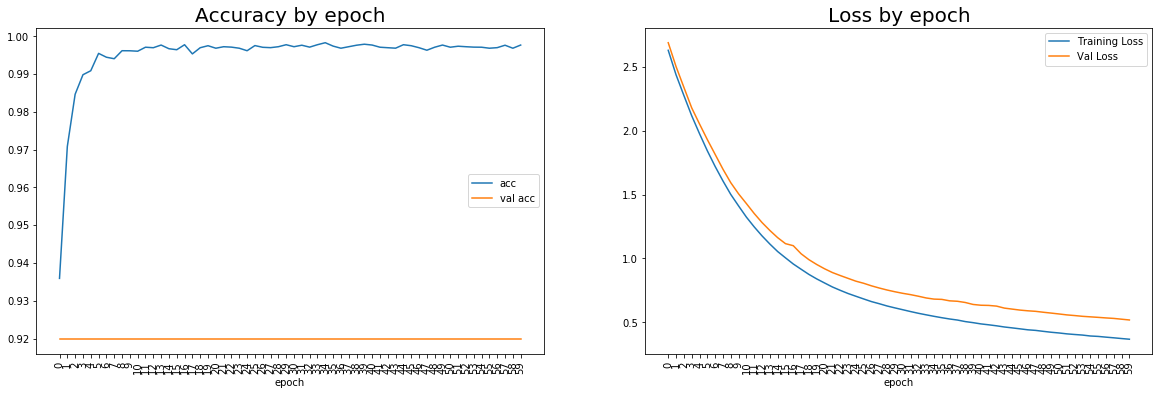

In [22]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(hist['acc'], label = 'acc')
plt.plot(hist['val_acc'], label = 'val acc')
plt.title('Accuracy by epoch', fontsize = 20)
plt.xticks(np.arange(0,len(hist['acc'])), rotation = 90);plt.xlabel('epoch')
plt.legend();

plt.subplot(1,2,2)
plt.plot(hist['loss'], label = 'Training Loss')
plt.plot(hist['val_loss'], label = 'Val Loss')
plt.title('Loss by epoch', fontsize = 20)
plt.xticks(np.arange(0,len(hist['acc'])), rotation = 90); plt.xlabel('epoch')
plt.legend();

### Make predictions

In [21]:
## TRAIN ACCURACY
gen_obj = ImageDataGenerator(rescale=1.0/255.0)
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir,  
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=train_data.shape[0], 
                                            shuffle=False, 
                                            seed=10)

train_preds = model.predict_generator(train_generator, steps = 1)
train_data['predicted_label'] = np.argmax(train_preds, axis = 1)
sum(train_data[y_column].astype('int') == train_data.predicted_label.astype('int'))/len(train_data)

Found 705 validated image filenames belonging to 3 classes.


0.4326241134751773

In [22]:
## TEST ACCURACY
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=test_data.shape[0], 
                                            shuffle=False,
                                            seed=10)

test_preds = model.predict_generator(test_generator, steps = 1)
test_data['predicted_label'] = np.argmax(test_preds, axis = 1)
sum(test_data.three_class_label.astype('int') == test_data.predicted_label.astype('int'))/len(test_data)

Found 401 validated image filenames belonging to 3 classes.


0.47381546134663344

### Visualization of results - 3 class model

Unfortunately, due to saving issues, we did not have the 2 class model. Instead, we visualize what happened while training the three class model. The model is having a hard time differentiating bw the three classes.

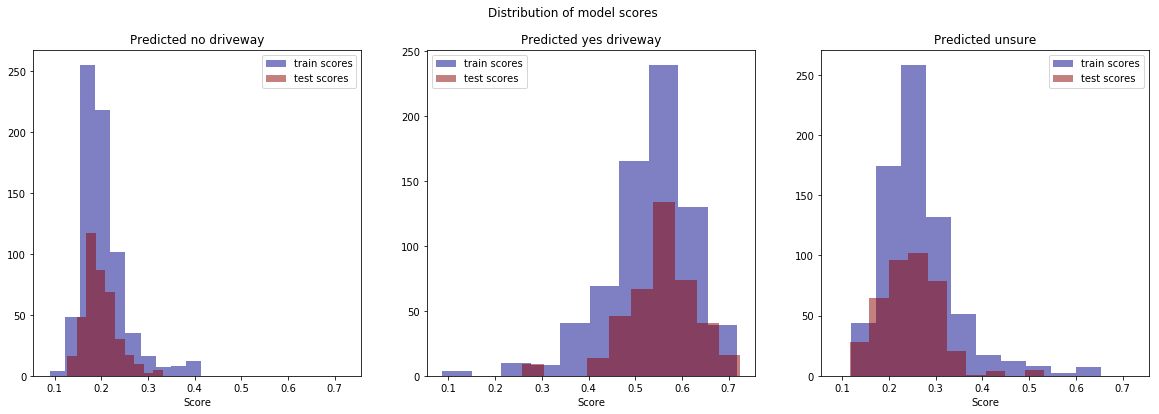

In [23]:
# binary prediction
if len(train_preds.shape) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    ax.hist(train_preds, color='darkblue', alpha=0.5, label='train scores')
    ax.hist(test_preds, color='darkred', alpha=0.5, label='test scores')
    ax.legend()
    ax.set_xlabel('Score')
    ax.set_title('Distribution of model scores');
    
elif len(train_preds.shape) > 1:
    label_map = {0: 'Predicted no driveway', 1: 'Predicted yes driveway', 2: 'Predicted unsure'}
    fig, ax = plt.subplots(1, train_preds.shape[1], sharex=True, figsize=(20,6))
    
    for i in range(train_preds.shape[1]):
        ax[i].hist(train_preds[:,i], color='darkblue', alpha=0.5, label='train scores')
        ax[i].hist(test_preds[:,i], color='darkred', alpha=0.5, label='test scores')
        ax[i].legend()
        ax[i].set_xlabel('Score')
        ax[i].set_title(label_map[i])
    fig.suptitle('Distribution of model scores');

In [29]:
# (train_data['three_class_label'] == train_data['predicted_label'])

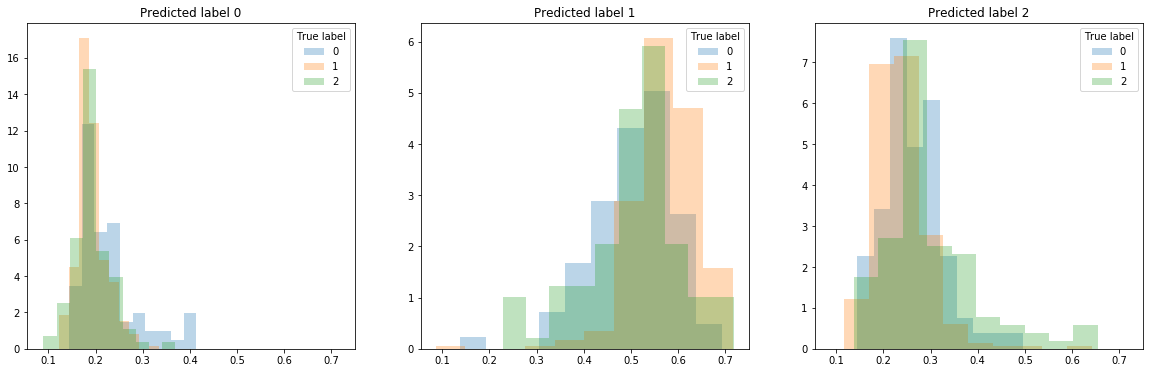

In [24]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,6))
for i in range(train_preds.shape[1]):
    for lab in ['0','1','2']:
        ax[i].hist(train_preds[train_data[y_column]==lab,i], alpha=0.3, density=True, label=lab)
    ax[i].legend(title='True label');
    ax[i].set_title('Predicted label ' + str(i))

### Save Models

In [25]:
model.save('../models/sv_transfer_model_learningratescheduler_es.h5')

In [26]:
model.save_weights('../models/sv_transfer_model_weights_learningratescheduler_es.h5')

In [ ]:
chk = load_model('../models/sv_transfer_model_learningratescheduler.h5')